In [51]:
!pip install nltk
!pip install emoji
!pip install umap
!pip install plotly


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


import os

# Création d'un répertoire local au cas où les chemins par défaut posent problème
nltk_data_dir = os.path.join(os.getcwd(), "nltk_data")
os.makedirs(nltk_data_dir, exist_ok=True)

# Ajout manuel au chemin
nltk.data.path.append(nltk_data_dir)

# Téléchargements des ressources nécessaires dans le bon répertoire
nltk.download("punkt", download_dir=nltk_data_dir)
nltk.download("stopwords", download_dir=nltk_data_dir)
nltk.download("wordnet", download_dir=nltk_data_dir)




[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


[nltk_data] Downloading package punkt to /Users/salhinina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/salhinina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/salhinina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/salhinina/Desktop/Mach
[nltk_data]     ine_learning/Projet/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/salhinina/Desktop/
[nltk_data]     Machine_learning/Projet/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/salhinina/Desktop/Ma
[nltk_data]     chine_learning/Projet/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [52]:
df=pd.read_csv('scitweets_export.tsv', sep='\t')
display (df.head())
print("Nombre total de lignes :", len(df))

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


Nombre total de lignes : 1140


In [53]:
#-------------------------------
#----Analyse du jeu de données – partie scientifique uniquement--------
#------------------------------

Nombre de lignes scientifiques : 375

Occurrences parmi les scientifiques :
- CLAIM + REF : 124
- CONTEXT uniquement : 33


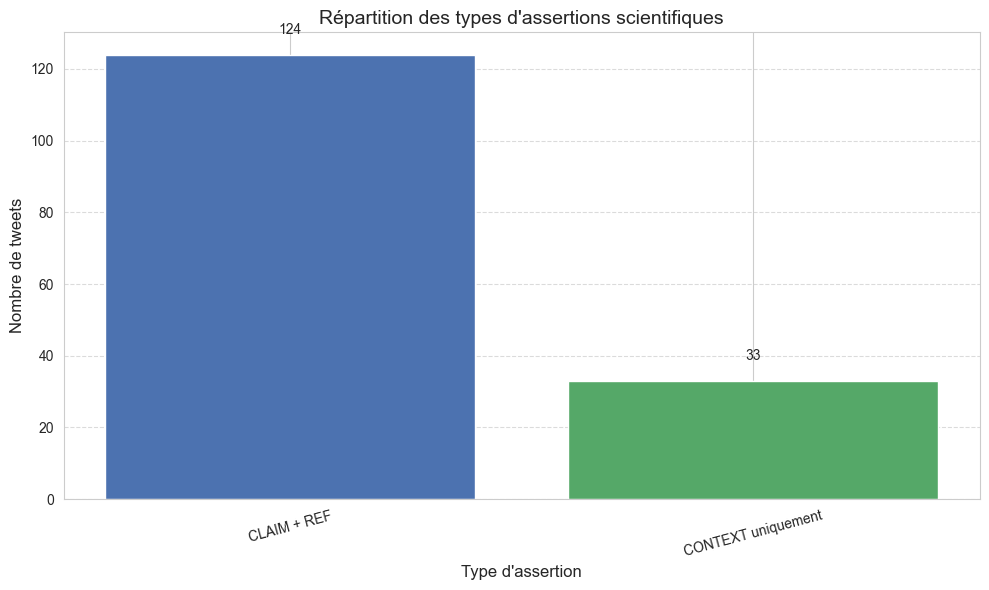

In [54]:
# 3. Filtrer les lignes scientifiques
df_sci = df[df["science_related"] == 1]
print("Nombre de lignes scientifiques :", len(df_sci))

# 4. Détailler les sous-catégories parmi les scientifiques

# c. CLAIM + REF
claim_ref = df_sci[(df_sci["scientific_claim"] == 1.0) &
                   (df_sci["scientific_reference"] == 1.0)]

# d. CONTEXT uniquement
context_only = df_sci[(df_sci["scientific_context"] == 1.0) &
                      (df_sci["scientific_claim"] == 0.0) &
                      (df_sci["scientific_reference"] == 0.0)]


# 5. Afficher les résultats
print("\nOccurrences parmi les scientifiques :")
print("- CLAIM + REF :", len(claim_ref))
print("- CONTEXT uniquement :", len(context_only))

# 4. Création du dictionnaire de comptage
counts = {
    "CLAIM + REF": len(claim_ref),
    "CONTEXT uniquement": len(context_only)
}

# 5. Création du DataFrame pour affichage
df_counts = pd.DataFrame(list(counts.items()), columns=["Catégorie", "Nombre"])

# 6. Affichage graphique
plt.figure(figsize=(10,6))
bars = plt.bar(df_counts["Catégorie"], df_counts["Nombre"], color=["#4C72B0", "#55A868", "#C44E52", "#8172B3"])
plt.title("Répartition des types d'assertions scientifiques", fontsize=14)
plt.xlabel("Type d'assertion", fontsize=12)
plt.ylabel("Nombre de tweets", fontsize=12)
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 7. Afficher les valeurs sur les barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, int(yval), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


In [55]:
#----------------------------------------------
#-----------------Reequilibrage de donnees -----------------------------
#----------------------------------------------

In [56]:
from sklearn.utils import resample


# ➤ Classe CONTEXT uniquement (scientific_context == 1.0 et claim & ref == 0.0)
df_context = df_sci[
    (df_sci["scientific_context"] == 1.0) &
    (df_sci["scientific_claim"] == 0.0) &
    (df_sci["scientific_reference"] == 0.0)
]

# ➤ Classe CLAIM/REF (claim == 1.0 et ref == 1.0), SANS context == 1.0
df_claim_ref = df_sci[(df_sci["scientific_claim"] == 1.0) &
                   (df_sci["scientific_reference"] == 1.0)]

# 4. Vérification du déséquilibre initial
print("Avant équilibrage :")
print("CLAIM/REF :", len(df_claim_ref))
print("CONTEXT   :", len(df_context))

# 5. Upsampling de CONTEXT vers la taille de CLAIM/REF
df_context_upsampled = resample(
    df_context,
    replace=True,
    n_samples=len(df_claim_ref),
    random_state=42
)

# 6. Fusion des deux sous-ensembles équilibrés
df_balanced = pd.concat([df_claim_ref, df_context_upsampled])

# 7. Shuffle du dataset pour mélanger
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 8. Formatage des donnees et création du label final : 
# 1 pour CLAIM/REF, 0 pour CONTEXT
df_balanced["label"] = df_balanced.apply(
    lambda row: 1 if (row["scientific_claim"] == 1.0 and row["scientific_reference"] == 1.0) else 0,
    axis=1
)

# 7. Vérification finale
print("\nAprès équilibrage :")
print(df_balanced["label"].value_counts())

print("CLAIM/REF :", len(df_claim_ref))
print("CONTEXT (upsampled) :", len(df_context_upsampled))
print("Total lignes :", len(df_balanced))


Avant équilibrage :
CLAIM/REF : 124
CONTEXT   : 33

Après équilibrage :
label
1    124
0    124
Name: count, dtype: int64
CLAIM/REF : 124
CONTEXT (upsampled) : 124
Total lignes : 248


In [57]:
# a partir de maintenant on travaille avce df_balanced 

In [58]:
display(df_balanced.head())
print("Nombre total de lignes :", len(df_balanced))

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context,label
0,394,685469159430336512,#EurekaMag The eclosion hormone its release by...,1,1.0,1.0,1.0,1
1,84,419047430718373888,.@GreenJournal study show this infection can i...,1,1.0,1.0,1.0,1
2,779,971041555875352576,From March 5 - 9 @FieldsInstitute's workshop o...,1,0.0,0.0,1.0,0
3,948,1110781653889089536,Tourists watch as 18 green turtles are release...,1,1.0,1.0,1.0,1
4,700,913722549770637312,"Science, Meaning and the Imagination: How can ...",1,0.0,0.0,1.0,0


Nombre total de lignes : 248


Nombre d'occurrences par classe (0 = CONTEXT, 1 = CLAIM/REF) :

label
1    124
0    124
Name: count, dtype: int64

Shape: (248, 8)


/var/folders/pf/x8z57h4121s6cmtp02twbdd00000gn/T/ipykernel_41405/416549444.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  plot = sb.countplot(x='label', data=dataFile, palette='pastel')
/var/folders/pf/x8z57h4121s6cmtp02twbdd00000gn/T/ipykernel_41405/416549444.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plot.set_xticklabels(['CONTEXT (0)', 'CLAIM/REF (1)'])


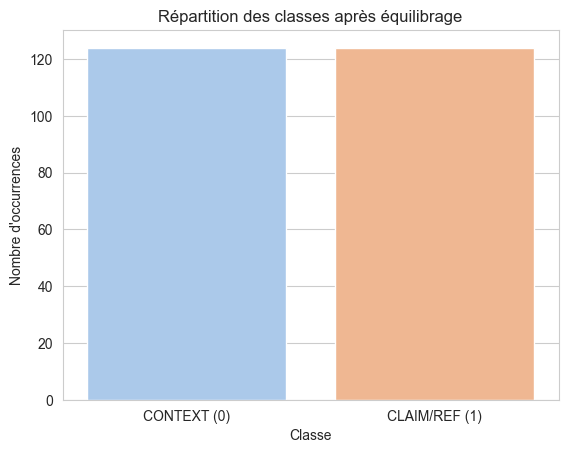

In [59]:
# 1. Afficher les occurrences par classe dans df_balanced
print("Nombre d'occurrences par classe (0 = CONTEXT, 1 = CLAIM/REF) :\n")
print(df_balanced['label'].value_counts())

# 2. Afficher la forme du dataset
print("\nShape:", df_balanced.shape)

# 3. Fonction pour créer une distribution avec seaborn
def create_distribution(dataFile):
    sb.set_style("whitegrid")
    plot = sb.countplot(x='label', data=dataFile, palette='pastel')
    plot.set_xticklabels(['CONTEXT (0)', 'CLAIM/REF (1)'])
    plt.title("Répartition des classes après équilibrage")
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'occurrences")
    plt.show()

# 4. Appel de la fonction
create_distribution(df_balanced)

In [60]:
#-------------------------------
#----Nettoyage + normalisation du texte--------
#------------------------------

In [61]:
import re
import emoji

# 1. Fonction pour convertir les emojis en texte
def convert_emojis(text):
    return emoji.demojize(text)  # Exemple : 😊 devient :smiling_face_with_smiling_eyes:

# Appliquer la conversion sur le texte
df_balanced['tweet_text'] = df_balanced['text'].apply(convert_emojis)

# 2. Détection des éléments textuels :

# Détection d’URL
df_balanced['has_url'] = df_balanced['text'].str.contains(r'http[s]?://', regex=True)

# Détection de mentions (@username)
df_balanced['has_mention'] = df_balanced['text'].str.contains(r'@\w+', regex=True)

# Détection de hashtags (#mot)
df_balanced['has_hashtag'] = df_balanced['text'].str.contains(r'#\w+', regex=True)

# Détection d'emojis (format texte après demojize)
df_balanced['has_emoji'] = df_balanced['text'].str.contains(r':[^:\s]+:', regex=True)

# 3. Fonction pour compter par catégorie et par classe (label 0 ou 1)
def count_by_category(col):
    return df_balanced.groupby('label')[col].sum()

# 4. Affichage des résultats :

print("- Tweets avec URL :")
display(count_by_category('has_url'))

print("- Tweets avec Mention :")
display(count_by_category('has_mention'))

print("- Tweets avec Hashtag :")
display(count_by_category('has_hashtag'))

print("- Tweets avec Emoji :")
display(count_by_category('has_emoji'))


- Tweets avec URL :


label
0    111
1    122
Name: has_url, dtype: int64

- Tweets avec Mention :


label
0    78
1    30
Name: has_mention, dtype: int64

- Tweets avec Hashtag :


label
0    62
1    35
Name: has_hashtag, dtype: int64

- Tweets avec Emoji :


label
0    0
1    0
Name: has_emoji, dtype: int64

In [62]:
#------------------------------------------------------------
#--------matrice tf-idf avce les données brut---------------
#-------------------------------------------------------------

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# ✅ Étape 1 : Nettoyage minimal (éviter les NaN sur le texte)
df_balanced.dropna(subset=['tweet_text'], inplace=True)

# ✅ Étape 2 : Sélection du texte brut et du label
X_text = df_balanced['tweet_text']  # Texte brut
y = df_balanced['label']            # Labels binaires (0 ou 1)

# ✅ Étape 3 : Création de la matrice TF-IDF à partir du texte brut
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_text)

# ✅ Étape 4 : Création de la matrice des features binaires supplémentaires
# Convertir les booléens en int (0 ou 1) si nécessaire
extra_features = df_balanced[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
X_extra = scipy.sparse.csr_matrix(extra_features.values)

# ✅ Étape 5 : Concaténer TF-IDF + features supplémentaires
X_final = scipy.sparse.hstack([X_tfidf, X_extra])

# ✅ Étape 6 : Affichage des tailles
print("📐 Taille de la matrice TF-IDF :", X_tfidf.shape)
print("📐 Taille des features supplémentaires :", X_extra.shape)
print("📐 Taille finale (TF-IDF + extra features) :", X_final.shape)


📐 Taille de la matrice TF-IDF : (248, 1794)
📐 Taille des features supplémentaires : (248, 4)
📐 Taille finale (TF-IDF + extra features) : (248, 1798)


In [64]:
import re
import pandas as pd

# ✅ Convertir la matrice TF-IDF en DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# ✅ Fonction de catégorisation des tokens
def get_token_category(token):
    if token.isdigit():
        return 'numeric'
    if re.match(r'^\d+(am|pm|s|h|min|sec|hour|years)?$', token.lower()):
        return 'timestamp'
    if re.match(r'^[a-zA-Z]+$', token):
        return 'valid'
    return 'other'

# ✅ Classer chaque token
token_categories = {token: get_token_category(token) for token in tfidf_df.columns}

# ✅ Regrouper par type
valid_tokens = [token for token, cat in token_categories.items() if cat == 'valid']
numeric_tokens = [token for token, cat in token_categories.items() if cat == 'numeric']
timestamp_tokens = [token for token, cat in token_categories.items() if cat == 'timestamp']

# ✅ Colonnes agrégées
tfidf_df['numeric'] = tfidf_df[numeric_tokens].sum(axis=1) if numeric_tokens else 0
tfidf_df['timestamp'] = tfidf_df[timestamp_tokens].sum(axis=1) if timestamp_tokens else 0

# ✅ Garder uniquement les tokens valides + colonnes synthétiques
tfidf_cleaned = tfidf_df[valid_tokens + ['numeric', 'timestamp']]

# ✅ Aperçu
print("📄 Aperçu de la matrice TF-IDF nettoyée (texte brut) :")
display(tfidf_cleaned.head())
print("📐 Taille finale :", tfidf_cleaned.shape)


📄 Aperçu de la matrice TF-IDF nettoyée (texte brut) :


,about,aca,academics,academy,access,according,account,acquired,acre,action,...,young,your,youth,yrmefiuzjy,yrs,zachary,zhengli,zika,numeric,timestamp
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.213612,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.383591,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0


📐 Taille finale : (248, 1571)


In [65]:
#------------------------------------------------------------
#--------Separation des donnees pour le train/test---------------
#-------------------------------------------------------------

In [66]:
from sklearn.model_selection import train_test_split

# ⚡ 80% entraînement, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_final,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y  # On stratify par y (pas df['science_related'], attention !)
)

# ✅ Affichage des tailles
print(f"Taille du jeu d'entraînement : {X_train.shape[0]} échantillons")
print(f"Taille du jeu de test : {X_test.shape[0]} échantillons")


Taille du jeu d'entraînement : 198 échantillons
Taille du jeu de test : 50 échantillons



🔍 Entraînement du modèle : Naïve Bayes

📊 Scores sur le Test Set : Naïve Bayes
Accuracy : 0.70 | Precision : 0.81 | Recall : 0.70 | F1 : 0.67
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        25
           1       1.00      0.40      0.57        25

    accuracy                           0.70        50
   macro avg       0.81      0.70      0.67        50
weighted avg       0.81      0.70      0.67        50

🧩 Matrice de confusion :
[[25  0]
 [15 10]]


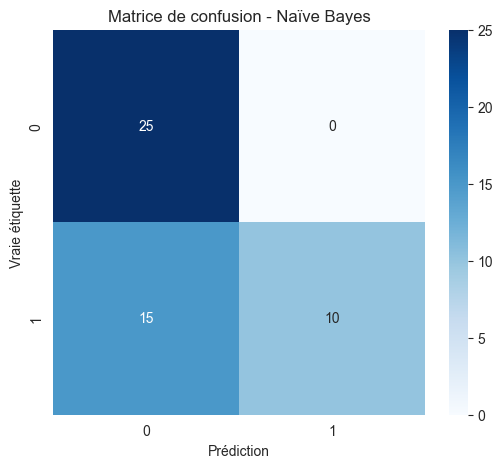

------------------------------------------------------------

🔍 Entraînement du modèle : Logistic Regression

📊 Scores sur le Test Set : Logistic Regression
Accuracy : 0.74 | Precision : 0.74 | Recall : 0.74 | F1 : 0.74
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.71      0.80      0.75        25
           1       0.77      0.68      0.72        25

    accuracy                           0.74        50
   macro avg       0.74      0.74      0.74        50
weighted avg       0.74      0.74      0.74        50

🧩 Matrice de confusion :
[[20  5]
 [ 8 17]]


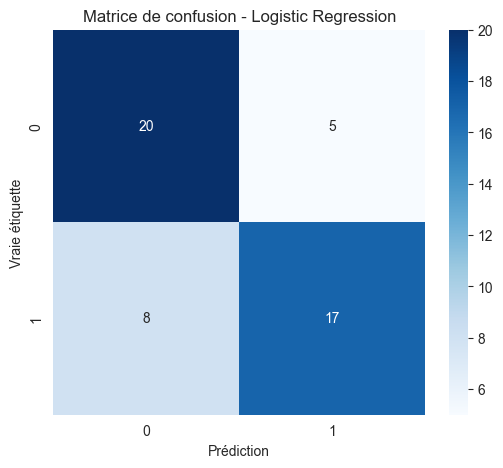

------------------------------------------------------------

🔍 Entraînement du modèle : Random Forest

📊 Scores sur le Test Set : Random Forest
Accuracy : 0.94 | Precision : 0.94 | Recall : 0.94 | F1 : 0.94
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.92      0.96      0.94        25
           1       0.96      0.92      0.94        25

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50

🧩 Matrice de confusion :
[[24  1]
 [ 2 23]]


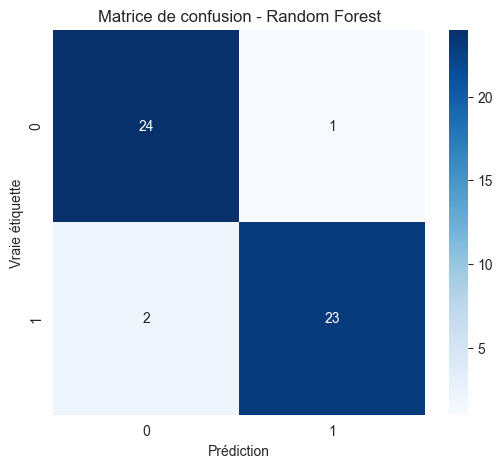

------------------------------------------------------------

🔍 Entraînement du modèle : SVM

📊 Scores sur le Test Set : SVM
Accuracy : 0.88 | Precision : 0.88 | Recall : 0.88 | F1 : 0.88
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        25
           1       0.88      0.88      0.88        25

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50

🧩 Matrice de confusion :
[[22  3]
 [ 3 22]]


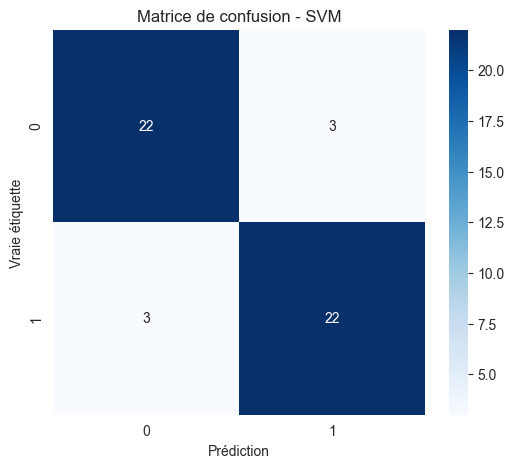

------------------------------------------------------------

🔍 Entraînement du modèle : KNN

📊 Scores sur le Test Set : KNN
Accuracy : 0.72 | Precision : 0.73 | Recall : 0.72 | F1 : 0.72
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.68      0.84      0.75        25
           1       0.79      0.60      0.68        25

    accuracy                           0.72        50
   macro avg       0.73      0.72      0.72        50
weighted avg       0.73      0.72      0.72        50

🧩 Matrice de confusion :
[[21  4]
 [10 15]]


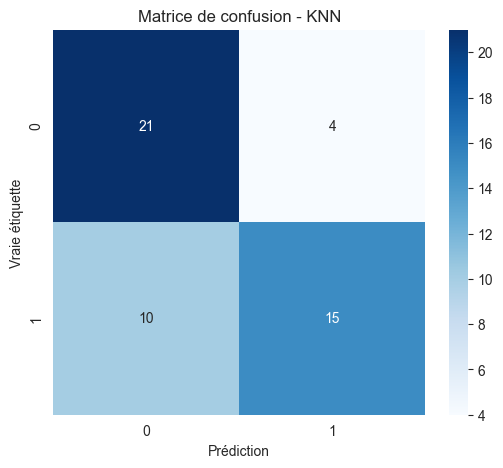

------------------------------------------------------------

🔍 Entraînement du modèle : AdaBoost

📊 Scores sur le Test Set : AdaBoost
Accuracy : 0.76 | Precision : 0.77 | Recall : 0.76 | F1 : 0.76
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.72      0.84      0.78        25
           1       0.81      0.68      0.74        25

    accuracy                           0.76        50
   macro avg       0.77      0.76      0.76        50
weighted avg       0.77      0.76      0.76        50

🧩 Matrice de confusion :
[[21  4]
 [ 8 17]]


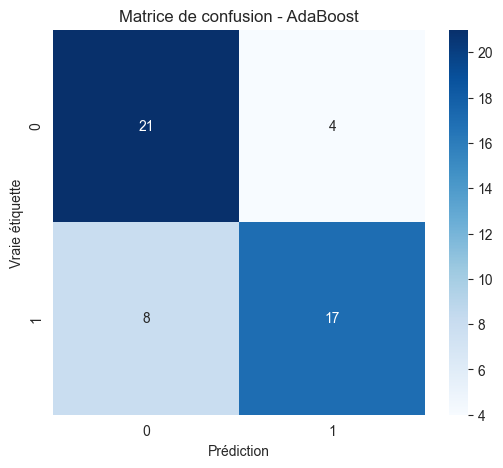

------------------------------------------------------------

🔍 Entraînement du modèle : XGBoost


/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters:


📊 Scores sur le Test Set : XGBoost
Accuracy : 0.86 | Precision : 0.88 | Recall : 0.86 | F1 : 0.86
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.80      0.96      0.87        25
           1       0.95      0.76      0.84        25

    accuracy                           0.86        50
   macro avg       0.88      0.86      0.86        50
weighted avg       0.88      0.86      0.86        50

🧩 Matrice de confusion :
[[24  1]
 [ 6 19]]


/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:30:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


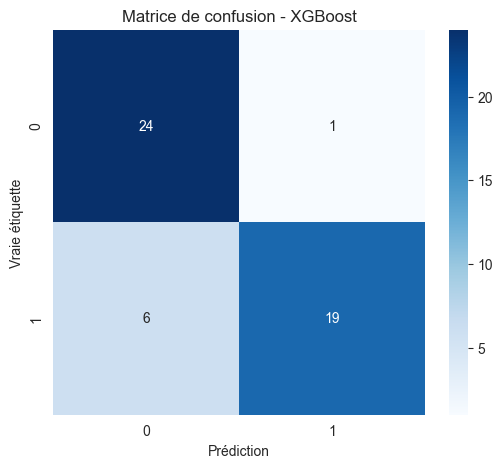

------------------------------------------------------------

🔍 Entraînement du modèle : Neural Network (MLP)

📊 Scores sur le Test Set : Neural Network (MLP)
Accuracy : 0.92 | Precision : 0.92 | Recall : 0.92 | F1 : 0.92
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        25
           1       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50

🧩 Matrice de confusion :
[[24  1]
 [ 3 22]]


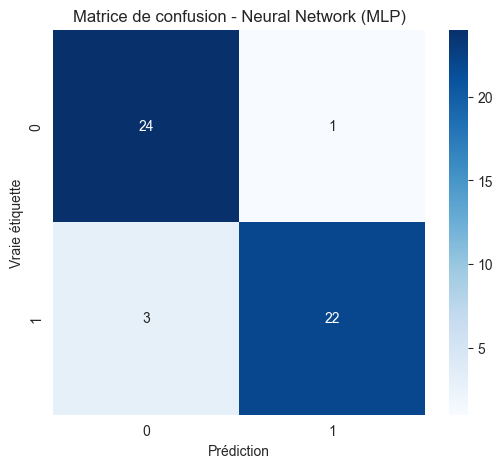

------------------------------------------------------------


,Accuracy,Precision,Recall,F1 Score,CV Accuracy,CV Precision,CV Recall,CV F1 Score
Naïve Bayes,0.70,0.81,0.70,0.67,0.81 ± 0.05,0.87 ± 0.02,0.81 ± 0.05,0.81 ± 0.05
Logistic Regression,0.74,0.74,0.74,0.74,0.87 ± 0.07,0.88 ± 0.06,0.87 ± 0.07,0.87 ± 0.07
Random Forest,0.94,0.94,0.94,0.94,0.99 ± 0.02,0.98 ± 0.03,0.98 ± 0.03,0.98 ± 0.02
SVM,0.88,0.88,0.88,0.88,0.92 ± 0.07,0.92 ± 0.07,0.92 ± 0.07,0.92 ± 0.07
KNN,0.72,0.73,0.72,0.72,0.75 ± 0.06,0.77 ± 0.06,0.75 ± 0.06,0.74 ± 0.06
AdaBoost,0.76,0.77,0.76,0.76,0.83 ± 0.03,0.84 ± 0.02,0.83 ± 0.03,0.83 ± 0.03
XGBoost,0.86,0.88,0.86,0.86,0.93 ± 0.03,0.94 ± 0.02,0.93 ± 0.03,0.93 ± 0.03
Neural Network (MLP),0.92,0.92,0.92,0.92,0.96 ± 0.03,0.97 ± 0.03,0.96 ± 0.04,0.96 ± 0.04


/var/folders/pf/x8z57h4121s6cmtp02twbdd00000gn/T/ipykernel_41405/2061697943.py:103: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


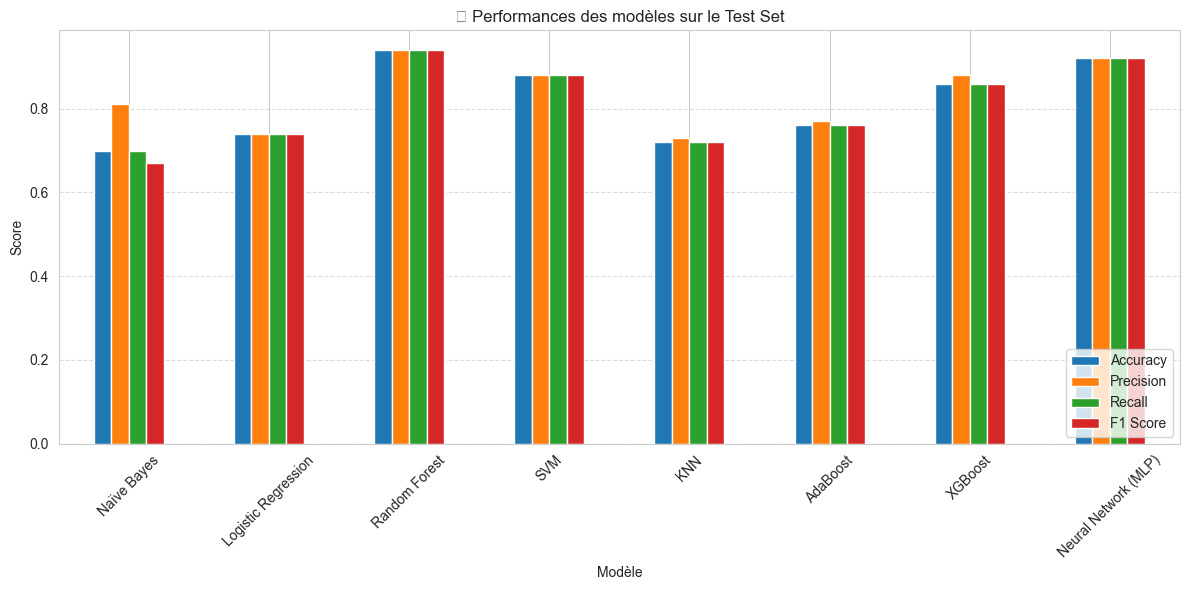

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold

# ✅ 1. Cross-validation stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ✅ 2. Liste de modèles
scores = {}
models = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Neural Network (MLP)": MLPClassifier(max_iter=300)
}

# ✅ 3. Définir les scorers pour la cross-validation
scorers = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score, average='weighted'),
    "Recall": make_scorer(recall_score, average='weighted'),
    "F1 Score": make_scorer(f1_score, average='weighted')
}

# ✅ 4. Boucle d'entraînement + évaluation
for name, model in models.items():
    print(f"\n🔍 Entraînement du modèle : {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Cross-validation
    cv_results = {}
    for metric_name, scorer in scorers.items():
        cv_scores = cross_val_score(model, X_final, y, cv=cv, scoring=scorer)
        mean = cv_scores.mean()
        std = cv_scores.std()
        cv_results[metric_name] = f"{mean:.2f} ± {std:.2f}"

    scores[name] = {
        "Accuracy": f"{acc:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}",
        "F1 Score": f"{f1:.2f}",
        "CV Accuracy": cv_results["Accuracy"],
        "CV Precision": cv_results["Precision"],
        "CV Recall": cv_results["Recall"],
        "CV F1 Score": cv_results["F1 Score"]
    }

    # 📄 Résultats détaillés
    print(f"\n📊 Scores sur le Test Set : {name}")
    print(f"Accuracy : {acc:.2f} | Precision : {precision:.2f} | Recall : {recall:.2f} | F1 : {f1:.2f}")
    print("📄 Classification Report :")
    print(classification_report(y_test, y_pred))
    print("🧩 Matrice de confusion :")
    print(confusion_matrix(y_test, y_pred))

    # 📊 Matrice de confusion graphique
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de confusion - {name}')
    plt.xlabel('Prédiction')
    plt.ylabel('Vraie étiquette')
    plt.show()
    print("-" * 60)

# ✅ 5. Résumé global des performances
df_scores = pd.DataFrame(scores).T

# 📋 Affichage de la table complète
display(df_scores)

# ✅ 6. Visualisation des scores simples
plot_df = df_scores[["Accuracy", "Precision", "Recall", "F1 Score"]].astype(float)

plot_df.plot(kind='bar', figsize=(12, 6))
plt.title("📊 Performances des modèles sur le Test Set")
plt.xlabel("Modèle")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
#------------------------------------------------------------
#--------a partir de la c'est avce pre-traitement---------------
#-------------------------------------------------------------

In [68]:
import re
import spacy
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# 🔹 Charger les modèles spaCy pour FR et EN
nlp_fr = spacy.load("fr_core_news_sm")
nlp_en = spacy.load("en_core_web_sm")

# 🔹 Fonction de nettoyage simple (lower, suppression URL, mentions, hashtags, ponctuation)
def clean_text_for_model(text):
    text = text.lower()
    text = re.sub(r"http\S+", "URL", text)
    text = re.sub(r"@\w+", "MENTION", text)
    text = re.sub(r"#(\w+)", r"\1", text)
    text = re.sub(r"[^\w\s:]", "", text)
    return text

# 🔹 Fonction de nettoyage + lemmatisation multilingue
def clean_and_lemmatize_multilang(text):
    text = clean_text_for_model(text)  # Nettoyage simple d'abord

    try:
        lang = detect(text)
    except:
        lang = "en"  # fallback sécurité

    if lang == "fr":
        doc = nlp_fr(text)
    else:
        doc = nlp_en(text)

    lemmatized = " ".join([token.lemma_ for token in doc if not token.is_stop])
    return lemmatized

# ✅ Appliquer la fonction à ton vrai dataset
df_balanced['text_clean'] = df_balanced['tweet_text'].apply(clean_and_lemmatize_multilang)

# ✅ Aperçu rapide
print("Aperçu du texte nettoyé + lemmatisé :")
display(df_balanced[['tweet_text', 'text_clean']].head())


Aperçu du texte nettoyé + lemmatisé :


,tweet_text,text_clean
0,#EurekaMag The eclosion hormone its release by...,eurekamag eclosion hormone release brain actio...
1,.@GreenJournal study show this infection can i...,MENTION study infection increase risk stroke h...
2,From March 5 - 9 @FieldsInstitute's workshop o...,march 5 9 mention workshop humanenvironment ...
3,Tourists watch as 18 green turtles are release...,tourist watch 18 green turtle release wild ind...
4,"Science, Meaning and the Imagination: How can ...",science meaning imagination : bring human scie...


In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
import scipy.sparse

# ✅ Nettoyage des valeurs manquantes sur le texte nettoyé
df_balanced.dropna(subset=['text_clean'], inplace=True)

# ✅ Texte et labels
X_text = df_balanced['text_clean']
y = df_balanced['label']

# ✅ TF-IDF vectorisation sur le texte nettoyé
print("⏳ Vectorisation TF-IDF en cours...")
vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(X_text)
print("✅ TF-IDF vectorisé.")

# ✅ Ajouter les colonnes binaires (URL, mention, hashtag, emoji)
extra_features = df_balanced[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
X_extra = scipy.sparse.csr_matrix(extra_features.values)

# ✅ Fusion TF-IDF + features supplémentaires
X_final = scipy.sparse.hstack([X_tfidf, X_extra])

# ✅ Affichage des tailles
print("📐 Taille de la matrice TF-IDF :", X_tfidf.shape)
print("📐 Taille des features supplémentaires :", X_extra.shape)
print("📐 Taille finale combinée :", X_final.shape)


⏳ Vectorisation TF-IDF en cours...
✅ TF-IDF vectorisé.
📐 Taille de la matrice TF-IDF : (248, 1261)
📐 Taille des features supplémentaires : (248, 4)
📐 Taille finale combinée : (248, 1265)


In [ ]:
#------------------------------------------------------------------
#-------pre-traitement commplet------------------------
#----------------------------------------------------

In [70]:
import re
import pandas as pd
import scipy.sparse
from sklearn.feature_extraction.text import TfidfVectorizer

# 🔹 Charger les stopwords français
stopwords_df = pd.read_csv("StopWordsFrench.csv", sep=',', index_col=0)
french_stopwords = stopwords_df.index.tolist()

# 🔹 Application nettoyage + lemmatisation sur df_balanced
print("⏳ Nettoyage + lemmatisation (version 2)...")
df_balanced['text_clean_2'] = df_balanced['tweet_text'].apply(clean_and_lemmatize_multilang)
print("✅ Texte nettoyé + lemmatisé (version 2).")

# 🔹 TF-IDF avancé (avec paramètres spécifiques)
vectorizer2 = TfidfVectorizer(
    min_df=5,
    max_df=0.95,
    stop_words=french_stopwords,
    lowercase=False,
    ngram_range=(1, 2),
    max_features=50000
)
X_tfidf2 = vectorizer2.fit_transform(df_balanced['text_clean_2'])

# ➕ DataFrame version 2
tfidf_df2 = pd.DataFrame(X_tfidf2.toarray(), columns=vectorizer2.get_feature_names_out())

# 🔹 Filtrage des tokens : uniquement lettres (supprimer chiffres isolés)
def is_valid_token(token):
    if token.isdigit():
        return False
    return bool(re.match(r'^[a-zA-Z]+$', token))

valid_columns2 = [token for token in tfidf_df2.columns if is_valid_token(token)]
numeric_columns2 = [token for token in tfidf_df2.columns if token.isdigit()]

# 🔹 Colonnes synthétiques pour numériques
tfidf_df2['numeric'] = tfidf_df2[numeric_columns2].sum(axis=1) if numeric_columns2 else 0
tfidf_df2.drop(columns=numeric_columns2, inplace=True)

# 🔹 On ne garde que les colonnes valides + numeric
tfidf_filtered_df2 = tfidf_df2[valid_columns2 + ['numeric']]

# 🔹 Features binaires déjà détectées
extra_features2 = df_balanced[['has_url', 'has_mention', 'has_hashtag', 'has_emoji']].astype(int)
X_extra2 = scipy.sparse.csr_matrix(extra_features2.values)

# 🔹 Fusion finale TF-IDF filtré + features binaires
X_final2 = scipy.sparse.hstack([scipy.sparse.csr_matrix(tfidf_filtered_df2.values), X_extra2])

# 🔹 Labels correspondants
y2 = df_balanced['label']

# 🔹 Affichage des tailles finales
print("📐 Taille TF-IDF filtrée (v2) :", tfidf_filtered_df2.shape)
print("📐 Taille finale avec features binaires (v2) :", X_final2.shape)


⏳ Nettoyage + lemmatisation (version 2)...
✅ Texte nettoyé + lemmatisé (version 2).
📐 Taille TF-IDF filtrée (v2) : (248, 161)
📐 Taille finale avec features binaires (v2) : (248, 165)


In [72]:
# ✅ 80% entraînement, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_final2,
    y2,
    test_size=0.2,
    random_state=42,
    stratify=y2  # on stratify bien sur y2 maintenant !
)

# ✅ Affichage des tailles
print(f"Taille du jeu d'entraînement : {X_train.shape[0]} échantillons")
print(f"Taille du jeu de test : {X_test.shape[0]} échantillons")

Taille du jeu d'entraînement : 198 échantillons
Taille du jeu de test : 50 échantillons



🔍 Entraînement du modèle : Naïve Bayes

📊 Scores sur le Test Set : Naïve Bayes
Accuracy : 0.90 | Precision : 0.90 | Recall : 0.90 | F1 : 0.90
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.88      0.92      0.90        25
           1       0.92      0.88      0.90        25

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50

🧩 Matrice de confusion :
[[23  2]
 [ 3 22]]


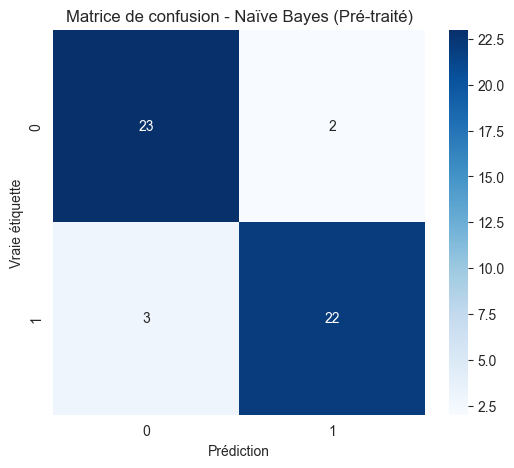

------------------------------------------------------------

🔍 Entraînement du modèle : Logistic Regression

📊 Scores sur le Test Set : Logistic Regression
Accuracy : 0.84 | Precision : 0.84 | Recall : 0.84 | F1 : 0.84
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        25
           1       0.84      0.84      0.84        25

    accuracy                           0.84        50
   macro avg       0.84      0.84      0.84        50
weighted avg       0.84      0.84      0.84        50

🧩 Matrice de confusion :
[[21  4]
 [ 4 21]]


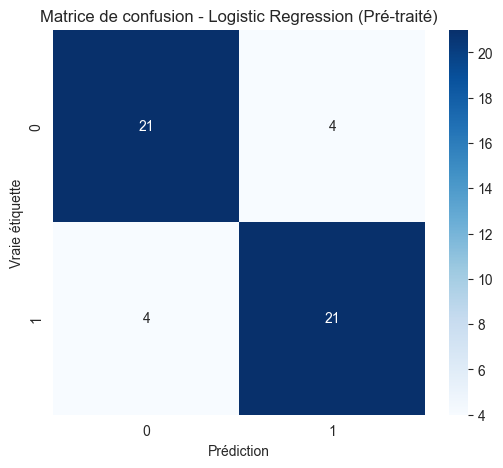

------------------------------------------------------------

🔍 Entraînement du modèle : Random Forest

📊 Scores sur le Test Set : Random Forest
Accuracy : 0.92 | Precision : 0.92 | Recall : 0.92 | F1 : 0.92
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        25
           1       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50

🧩 Matrice de confusion :
[[24  1]
 [ 3 22]]


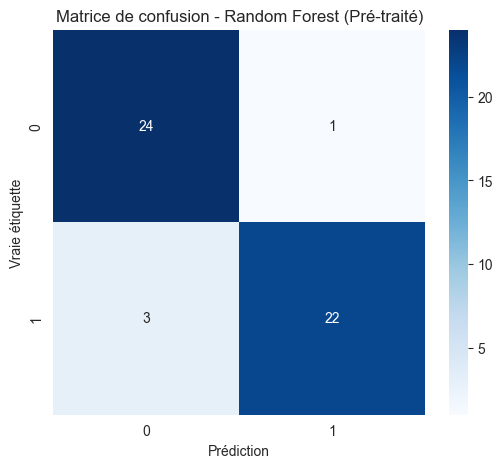

------------------------------------------------------------

🔍 Entraînement du modèle : SVM (linéaire)

📊 Scores sur le Test Set : SVM (linéaire)
Accuracy : 0.92 | Precision : 0.92 | Recall : 0.92 | F1 : 0.92
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.89      0.96      0.92        25
           1       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50

🧩 Matrice de confusion :
[[24  1]
 [ 3 22]]


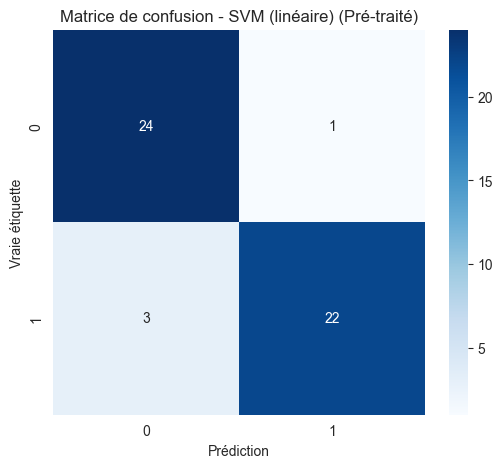

------------------------------------------------------------

🔍 Entraînement du modèle : KNN

📊 Scores sur le Test Set : KNN
Accuracy : 0.78 | Precision : 0.78 | Recall : 0.78 | F1 : 0.78
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.75      0.84      0.79        25
           1       0.82      0.72      0.77        25

    accuracy                           0.78        50
   macro avg       0.78      0.78      0.78        50
weighted avg       0.78      0.78      0.78        50

🧩 Matrice de confusion :
[[21  4]
 [ 7 18]]


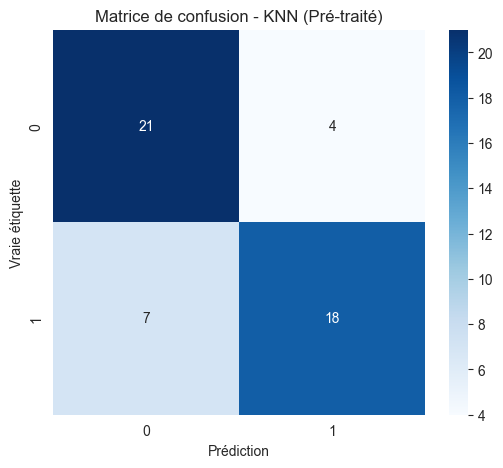

------------------------------------------------------------

🔍 Entraînement du modèle : AdaBoost

📊 Scores sur le Test Set : AdaBoost
Accuracy : 0.88 | Precision : 0.88 | Recall : 0.88 | F1 : 0.88
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        25
           1       0.91      0.84      0.88        25

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50

🧩 Matrice de confusion :
[[23  2]
 [ 4 21]]


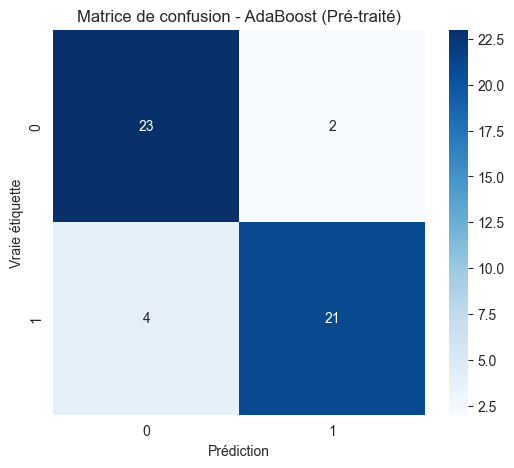

------------------------------------------------------------

🔍 Entraînement du modèle : XGBoost


/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:39:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:39:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:39:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:39:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters:


📊 Scores sur le Test Set : XGBoost
Accuracy : 0.94 | Precision : 0.95 | Recall : 0.94 | F1 : 0.94
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        25
           1       1.00      0.88      0.94        25

    accuracy                           0.94        50
   macro avg       0.95      0.94      0.94        50
weighted avg       0.95      0.94      0.94        50

🧩 Matrice de confusion :
[[25  0]
 [ 3 22]]


/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:39:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


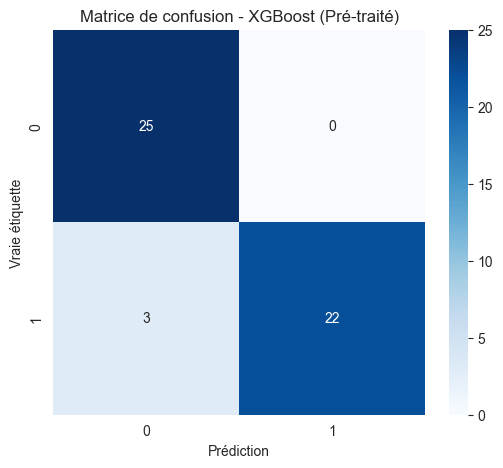

------------------------------------------------------------

🔍 Entraînement du modèle : Neural Network (MLP)


/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.wa


📊 Scores sur le Test Set : Neural Network (MLP)
Accuracy : 0.94 | Precision : 0.95 | Recall : 0.94 | F1 : 0.94
📄 Classification Report :
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        25
           1       1.00      0.88      0.94        25

    accuracy                           0.94        50
   macro avg       0.95      0.94      0.94        50
weighted avg       0.95      0.94      0.94        50

🧩 Matrice de confusion :
[[25  0]
 [ 3 22]]


/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


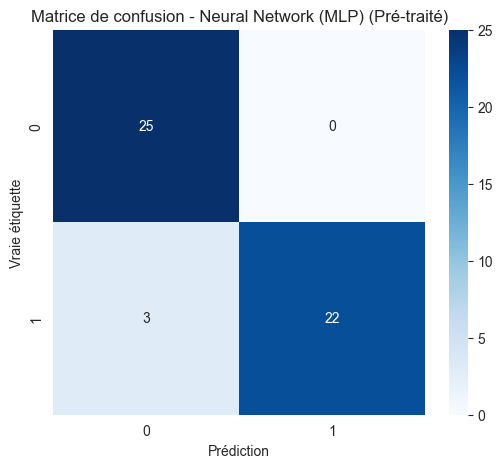

------------------------------------------------------------


,Accuracy,Precision,Recall,F1 Score,CV Accuracy,CV Precision,CV Recall,CV F1 Score
Naïve Bayes,0.90,0.90,0.90,0.90,0.90 ± 0.06,0.91 ± 0.06,0.90 ± 0.06,0.90 ± 0.06
Logistic Regression,0.84,0.84,0.84,0.84,0.89 ± 0.05,0.90 ± 0.05,0.89 ± 0.05,0.89 ± 0.05
Random Forest,0.92,0.92,0.92,0.92,0.95 ± 0.04,0.96 ± 0.04,0.94 ± 0.04,0.95 ± 0.04
SVM (linéaire),0.92,0.92,0.92,0.92,0.91 ± 0.04,0.91 ± 0.04,0.91 ± 0.04,0.91 ± 0.04
KNN,0.78,0.78,0.78,0.78,0.81 ± 0.09,0.83 ± 0.08,0.81 ± 0.09,0.81 ± 0.09
AdaBoost,0.88,0.88,0.88,0.88,0.88 ± 0.05,0.89 ± 0.05,0.88 ± 0.05,0.88 ± 0.05
XGBoost,0.94,0.95,0.94,0.94,0.92 ± 0.04,0.92 ± 0.04,0.92 ± 0.04,0.92 ± 0.04
Neural Network (MLP),0.94,0.95,0.94,0.94,0.94 ± 0.03,0.95 ± 0.03,0.94 ± 0.04,0.94 ± 0.04


/var/folders/pf/x8z57h4121s6cmtp02twbdd00000gn/T/ipykernel_41405/2358947372.py:103: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


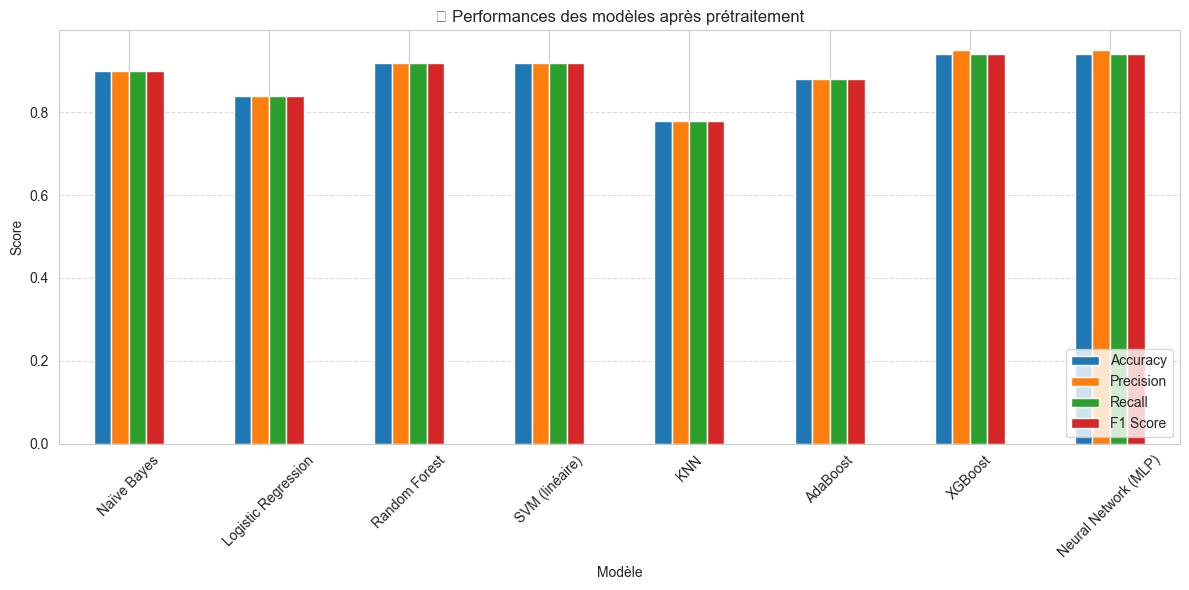

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, StratifiedKFold

# ✅ 1. Cross-validation stratifiée
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# ✅ 2. Liste des modèles
scores_v2 = {}  # <-- Nouvelle table pour version 2 (pré-traitement)
models = {
    "Naïve Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(),
    "SVM (linéaire)": SVC(kernel='linear'),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Neural Network (MLP)": MLPClassifier(max_iter=300)
}

# ✅ 3. Définir les scorers personnalisés
scorers = {
    "Accuracy": make_scorer(accuracy_score),
    "Precision": make_scorer(precision_score, average='weighted'),
    "Recall": make_scorer(recall_score, average='weighted'),
    "F1 Score": make_scorer(f1_score, average='weighted')
}

# ✅ 4. Entraînement + Évaluation + Cross-validation
for name, model in models.items():
    print(f"\n🔍 Entraînement du modèle : {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Cross-validation
    cv_results = {}
    for metric_name, scorer in scorers.items():
        cv_scores = cross_val_score(model, X_final2, y2, cv=cv, scoring=scorer)
        mean = cv_scores.mean()
        std = cv_scores.std()
        cv_results[metric_name] = f"{mean:.2f} ± {std:.2f}"

    scores_v2[name] = {
        "Accuracy": f"{acc:.2f}",
        "Precision": f"{precision:.2f}",
        "Recall": f"{recall:.2f}",
        "F1 Score": f"{f1:.2f}",
        "CV Accuracy": cv_results["Accuracy"],
        "CV Precision": cv_results["Precision"],
        "CV Recall": cv_results["Recall"],
        "CV F1 Score": cv_results["F1 Score"]
    }

    # 📄 Résultats détaillés
    print(f"\n📊 Scores sur le Test Set : {name}")
    print(f"Accuracy : {acc:.2f} | Precision : {precision:.2f} | Recall : {recall:.2f} | F1 : {f1:.2f}")
    print("📄 Classification Report :")
    print(classification_report(y_test, y_pred))
    print("🧩 Matrice de confusion :")
    print(confusion_matrix(y_test, y_pred))

    # 🧩 Matrice de confusion graphique
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matrice de confusion - {name} (Pré-traité)')
    plt.xlabel('Prédiction')
    plt.ylabel('Vraie étiquette')
    plt.show()
    print("-" * 60)

# ✅ 5. Résumé des scores V2
df_scores_v2 = pd.DataFrame(scores_v2).T

# 📋 Affichage de la table complète
display(df_scores_v2)

# ✅ 6. Visualisation des scores simples
plot_df_v2 = df_scores_v2[["Accuracy", "Precision", "Recall", "F1 Score"]].astype(float)

plot_df_v2.plot(kind='bar', figsize=(12, 6))
plt.title("📊 Performances des modèles après prétraitement")
plt.xlabel("Modèle")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="lower right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [74]:
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# ✅ Définir la fonction objectif pour tuner MLP
def objective_mlp(trial):
    # Paramètres à optimiser
    hidden_layer_sizes = trial.suggest_categorical("hidden_layer_sizes", [(50,), (100,), (50, 50), (100, 50)])
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    alpha = trial.suggest_float("alpha", 1e-5, 1e-1, log=True)  # Regularisation

    # Modèle MLP
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        max_iter=500,
        random_state=42,
        early_stopping=True  # Pour éviter l'overfitting
    )

    # Entraînement
    model.fit(X_train, y_train)
    
    # Prédiction
    y_pred = model.predict(X_test)

    # Score d'accuracy
    return accuracy_score(y_test, y_pred)

# ✅ Créer une étude Optuna
study_mlp = optuna.create_study(direction="maximize")
study_mlp.optimize(objective_mlp, n_trials=50)  # Tu peux ajuster le nombre d'essais ici (ex: 50, 100, 500)

# ✅ Résultats finaux
print("\n=== Résultats Optuna pour Neural Network (MLP) ===")
print("Meilleurs paramètres trouvés :", study_mlp.best_params)
print(f"Meilleure accuracy obtenue : {study_mlp.best_value:.4f}")


/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-26 14:43:44,211] A new study created in memory with name: no-name-c727cc96-5117-459b-876e-9cccc3b16be2
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (50,) which is of type tuple.
  warnings.warn(message)
/Users/salhinina/Desktop/mon_env/lib/python3.12/site-packages/optuna/distributions.py:515: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/Users/salhinina/Desktop/mon_env/lib/python3.1


=== Résultats Optuna pour Neural Network (MLP) ===
Meilleurs paramètres trouvés : {'hidden_layer_sizes': (100,), 'learning_rate_init': 0.015936518366350197, 'alpha': 0.006139752779244832}
Meilleure accuracy obtenue : 0.9600
